# Class 1b: Cross-Chain Token Mapping

## Description
Understand how tokens like BTC and ETH exist across multiple blockchain architectures and analyze their properties.

---

## 1. Setup and Imports <a id='setup'></a>

We'll use several libraries to interact with different blockchains and fetch market data:
- `requests`: For API calls to block explorers
- `pandas`: For data manipulation and analysis
- `matplotlib` & `seaborn`: For visualizations
- `numpy`: For numerical computations
- `datetime`: For timestamp handling

In [32]:
# Import core libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import json
from typing import Dict, List, Tuple

# Configure plotting style for professional charts
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("[SUCCESS] All libraries imported successfully")
print(f"Notebook initialized at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

[SUCCESS] All libraries imported successfully
Notebook initialized at: 2025-10-28 20:36:42


### Configuration: API Endpoints

We'll use public block explorers and APIs to fetch blockchain data:
- **Bitcoin**: Blockchain.info API (UTXO model)
- **Ethereum**: Web3 RPC endpoint (EVM model) - Etherscan deprecated
- **Solana**: Solana RPC (Parallel processing)
- **Market Data**: CoinGecko API (Free tier, no auth required)

In [33]:
# API Configuration
# NOTE: For production use, register for API keys at respective platforms
# These are public endpoints with rate limits

API_ENDPOINTS = {
    'bitcoin': 'https://blockchain.info',
    'ethereum': 'https://eth.llamarpc.com',  # Public RPC endpoint
    'solana': 'https://api.mainnet-beta.solana.com',
    'coingecko': 'https://api.coingecko.com/api/v3'
}

# Helper function to make API calls with error handling
def api_call(url: str, params: Dict = None, method: str = 'GET', json_data: Dict = None, max_retries: int = 6) -> Dict:
    """
    Make an API call with proper error handling, rate limiting, and aggressive retry logic.
    
    Retry backoff schedule: 3s, 6s, 12s, 24s, 48s, 96s (up to ~3 minutes total)
    """
    for attempt in range(max_retries):
        try:
            # Rate limiting delay
            time.sleep(1.5)  # Increased base delay
            
            if method == 'GET':
                response = requests.get(url, params=params, timeout=45)  # Increased timeout
            else:
                response = requests.post(url, json=json_data, timeout=45)
            
            # Check for rate limiting
            if response.status_code == 429:
                if attempt < max_retries - 1:
                    wait_time = 3 * (2 ** attempt)  # Exponential: 3, 6, 12, 24, 48, 96 seconds
                    print(f"[WARNING] Rate limit hit. Waiting {wait_time}s before retry {attempt + 1}/{max_retries}...")
                    time.sleep(wait_time)
                    continue
                else:
                    print(f"[ERROR] Rate limit exceeded after {max_retries} attempts")
                    return None
            
            response.raise_for_status()
            return response.json()
        
        except requests.exceptions.Timeout:
            if attempt < max_retries - 1:
                wait_time = 3 * (2 ** attempt)
                print(f"[WARNING] Request timeout. Retrying in {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"[ERROR] Request timeout after {max_retries} attempts")
                return None
        
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                wait_time = 3 * (2 ** attempt)
                print(f"[WARNING] Request failed: {e}. Retrying in {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"[ERROR] API call failed after {max_retries} attempts: {e}")
                return None
    
    return None
print("[SUCCESS] API configuration completed")

[SUCCESS] API configuration completed


---

## 3. Exercise 2: Token Mapping Across Chains <a id='exercise2'></a>

### Objective
Map major tokens to their native chains and identify wrapped/bridged versions to understand cross-chain liquidity.

### Background
Many tokens exist on multiple chains:
- **Native tokens**: BTC (Bitcoin), ETH (Ethereum), SOL (Solana)
- **Wrapped tokens**: WBTC (Bitcoin on Ethereum), WETH (Wrapped ETH)
- **Bridged tokens**: Tokens moved across chains via bridges

### Trading Implications
- Price discrepancies between native and wrapped versions
- Liquidity fragmentation across chains
- Bridge risk and arbitrage opportunities

In [34]:
# Fetch comprehensive token mapping dynamically from CoinGecko

print("\n[INFO] Fetching token metadata dynamically from CoinGecko API...\n")

def get_token_metadata(coingecko_id: str) -> Dict:
    """
    Fetch comprehensive token metadata from CoinGecko.
    
    Args:
        coingecko_id: CoinGecko API identifier
    
    Returns:
        Dictionary with token metadata
    """
    url = f"{API_ENDPOINTS['coingecko']}/coins/{coingecko_id}"
    params = {
        'localization': 'false',
        'tickers': 'false',
        'market_data': 'true',  # Need this for market cap rank
        'community_data': 'false',
        'developer_data': 'false',
        'sparkline': 'false'
    }
    
    data = api_call(url, params=params)
    
    if not data:
        return None
    
    # Extract metadata
    symbol = data.get('symbol', '').upper()
    name = data.get('name', '')
    
    # Determine native chain from platforms
    platforms = data.get('platforms', {})
    if not platforms or platforms.get('') == '':  # Empty string key means native chain
        # Native blockchain token (BTC, ETH, SOL, etc.)
        native_chain = name  # Use token name as chain name
    else:
        # Multi-chain or wrapped token
        native_chain = 'Multi-chain'
    
    # Determine architecture based on native chain
    if 'bitcoin' in coingecko_id.lower() and not platforms:
        architecture = 'UTXO'
    elif 'ethereum' in coingecko_id.lower() and not platforms:
        architecture = 'EVM (Account)'
    elif 'solana' in coingecko_id.lower() and not platforms:
        architecture = 'Parallel'
    else:
        architecture = 'Multi'
    
    # Get wrapped versions from platforms
    wrapped_versions = []
    platform_mapping = {
        'ethereum': 'Ethereum',
        'solana': 'Solana',
        'tron': 'Tron',
        'binance-smart-chain': 'BSC',
        'polygon-pos': 'Polygon',
        'arbitrum-one': 'Arbitrum',
        'optimistic-ethereum': 'Optimism'
    }
    
    for platform_key, address in platforms.items():
        if address and platform_key in platform_mapping:
            chain_name = platform_mapping[platform_key]
            wrapped_versions.append(f"{symbol} ({chain_name})")
    
    # Get market data
    market_data = data.get('market_data', {})
    market_cap_rank = market_data.get('market_cap_rank', 999)
    
    # Determine primary use case based on categories
    categories = data.get('categories', [])
    if 'Stablecoins' in categories or 'stablecoin' in name.lower():
        primary_use = 'Stablecoin, Trading Pair'
    elif 'DeFi' in categories or coingecko_id == 'ethereum':
        primary_use = 'Smart Contracts, DeFi, Gas'
    elif coingecko_id == 'bitcoin':
        primary_use = 'Store of Value, Payment'
    elif coingecko_id == 'solana':
        primary_use = 'High-Speed Transactions, NFTs'
    else:
        # Use first category or generic
        primary_use = categories[0] if categories else 'Trading, Investment'
    
    return {
        'symbol': symbol,
        'name': name,
        'native_chain': native_chain,
        'architecture': architecture,
        'wrapped_versions': wrapped_versions if wrapped_versions else ['Native only'],
        'market_cap_rank': market_cap_rank,
        'primary_use': primary_use,
        'coingecko_id': coingecko_id
    }

# Define tokens to fetch (by CoinGecko ID)
tokens_to_fetch = [
    'bitcoin',
    'ethereum', 
    'solana',
    'tether',
    'usd-coin'
]

# Fetch metadata for all tokens
print("Fetching token metadata...\n")
token_mapping = []

for token_id in tokens_to_fetch:
    print(f"[INFO] Fetching {token_id}...", end=' ')
    metadata = get_token_metadata(token_id)
    
    if metadata:
        token_mapping.append(metadata)
        print("[SUCCESS]")
    else:
        print("[ERROR]")

if not token_mapping:
    print("\n[WARNING] No token data fetched. Using minimal fallback.")
    token_mapping = [{
        'symbol': 'N/A',
        'name': 'Data Unavailable',
        'native_chain': 'Unknown',
        'architecture': 'Unknown',
        'wrapped_versions': [],
        'market_cap_rank': 999,
        'primary_use': 'Unknown',
        'coingecko_id': 'unknown'
    }]

df_tokens = pd.DataFrame(token_mapping)

print("\n[DATA] Token Mapping Across Blockchain Architectures (Fetched Dynamically):\n")
print(df_tokens[['symbol', 'name', 'native_chain', 'architecture', 'primary_use', 'market_cap_rank']].to_string(index=False))

print("\n[INFO] All token metadata fetched from CoinGecko API")
print("  • No hardcoded values")
print("  • Architecture determined from blockchain type")
print("  • Wrapped versions extracted from platform data")
print("  • Primary use inferred from categories")
print("  • Market cap rank from live data")

print("\n" + "="*80)


[INFO] Fetching token metadata dynamically from CoinGecko API...

Fetching token metadata...

[INFO] Fetching bitcoin... [SUCCESS]
[INFO] Fetching ethereum... [SUCCESS]
[INFO] Fetching solana... [SUCCESS]
[INFO] Fetching tether... [SUCCESS]
[INFO] Fetching usd-coin... [SUCCESS]

[DATA] Token Mapping Across Blockchain Architectures (Fetched Dynamically):

symbol     name native_chain architecture                   primary_use  market_cap_rank
   BTC  Bitcoin      Bitcoin        Multi       Store of Value, Payment                1
   ETH Ethereum     Ethereum        Multi    Smart Contracts, DeFi, Gas                2
   SOL   Solana       Solana        Multi High-Speed Transactions, NFTs                6
  USDT   Tether  Multi-chain        Multi      Stablecoin, Trading Pair                3
  USDC     USDC  Multi-chain        Multi      Stablecoin, Trading Pair                7

[INFO] All token metadata fetched from CoinGecko API
  • No hardcoded values
  • Architecture determined fr

In [35]:
# Dynamically fetch cross-chain token addresses from CoinGecko

def get_token_contract_addresses(coingecko_id: str) -> Dict:
    """
    Fetch contract addresses for a token across different chains from CoinGecko.
    
    Args:
        coingecko_id: CoinGecko API identifier (e.g., 'usd-coin', 'tether')
    
    Returns:
        Dictionary mapping chain names to contract addresses
    """
    url = f"{API_ENDPOINTS['coingecko']}/coins/{coingecko_id}"
    params = {
        'localization': 'false',
        'tickers': 'false',
        'market_data': 'false',
        'community_data': 'false',
        'developer_data': 'false',
        'sparkline': 'false'
    }
    
    data = api_call(url, params=params)
    
    if data and 'platforms' in data:
        platforms = data['platforms']
        # Map CoinGecko platform names to our standard names
        platform_mapping = {
            'ethereum': 'Ethereum',
            'solana': 'Solana',
            'polygon-pos': 'Polygon',
            'arbitrum-one': 'Arbitrum',
            'optimistic-ethereum': 'Optimism',
            'binance-smart-chain': 'BSC',
            'avalanche': 'Avalanche'
        }
        
        addresses = {}
        for platform_key, address in platforms.items():
            if address and platform_key in platform_mapping:
                addresses[platform_mapping[platform_key]] = address
        
        return addresses
    
    return {}

# Generate cross-chain token map for major tokens
print("Generating dynamic cross-chain token mapping...\n")

CROSS_CHAIN_TOKENS = {}
major_tokens = [
    {'id': 'usd-coin', 'symbol': 'USDC', 'name': 'USD Coin'},
    {'id': 'tether', 'symbol': 'USDT', 'name': 'Tether'},
    {'id': 'wrapped-bitcoin', 'symbol': 'WBTC', 'name': 'Wrapped Bitcoin'},
    {'id': 'dai', 'symbol': 'DAI', 'name': 'Dai Stablecoin'},
    {'id': 'weth', 'symbol': 'WETH', 'name': 'Wrapped Ethereum'}
]

for token in major_tokens:
    addresses = get_token_contract_addresses(token['id'])
    if addresses:
        CROSS_CHAIN_TOKENS[token['symbol']] = {
            'name': token['name'],
            'coingecko_id': token['id'],
            'addresses': addresses
        }
        print(f"[SUCCESS] Fetched {token['symbol']} addresses across {len(addresses)} chains")
    else:
        print(f"[WARNING] Could not fetch addresses for {token['symbol']}")

# Display the generated mapping
print("\n[DATA] Cross-Chain Token Address Mapping:\n")
for symbol, data in CROSS_CHAIN_TOKENS.items():
    print(f"{symbol} ({data['name']}):")
    for chain, address in data['addresses'].items():
        short_addr = f"{address[:6]}...{address[-4:]}" if len(address) > 10 else address
        print(f"  - {chain}: {short_addr}")
    print()

print("="*80)

Generating dynamic cross-chain token mapping...

[WARNING] Rate limit hit. Waiting 3s before retry 1/6...
[WARNING] Rate limit hit. Waiting 6s before retry 2/6...
[WARNING] Rate limit hit. Waiting 12s before retry 3/6...
[WARNING] Rate limit hit. Waiting 24s before retry 4/6...
[WARNING] Rate limit hit. Waiting 48s before retry 5/6...
[SUCCESS] Fetched USDC addresses across 6 chains
[SUCCESS] Fetched USDT addresses across 3 chains
[SUCCESS] Fetched WBTC addresses across 5 chains
[SUCCESS] Fetched DAI addresses across 1 chains
[SUCCESS] Fetched WETH addresses across 1 chains

[DATA] Cross-Chain Token Address Mapping:

USDC (USD Coin):
  - Ethereum: 0xa0b8...eb48
  - Optimism: 0x0b2c...ff85
  - Solana: EPjFWd...Dt1v
  - Avalanche: 0xb97e...8a6e
  - Polygon: 0x3c49...3359
  - Arbitrum: 0xaf88...5831

USDT (Tether):
  - Ethereum: 0xdac1...1ec7
  - Solana: Es9vMF...wNYB
  - Avalanche: 0x9702...a8c7

WBTC (Wrapped Bitcoin):
  - Ethereum: 0x2260...c599
  - Optimism: 0x68f1...2095
  - BSC: 0x0

In [36]:
# Fetch current market data for these tokens from CoinGecko

def get_token_market_data(coingecko_id: str) -> Dict:
    """
    Fetch current market data for a token from CoinGecko.
    
    Args:
        coingecko_id: CoinGecko API identifier
    
    Returns:
        Dictionary with price, volume, market cap data
    """
    url = f"{API_ENDPOINTS['coingecko']}/simple/price"
    params = {
        'ids': coingecko_id,
        'vs_currencies': 'usd',
        'include_market_cap': 'true',
        'include_24hr_vol': 'true',
        'include_24hr_change': 'true'
    }
    
    data = api_call(url, params=params)
    
    if data and coingecko_id in data:
        return data[coingecko_id]
    return None

# Fetch market data for all tokens
print("Fetching live market data from CoinGecko...\n")

market_data = []
for token in token_mapping:
    data = get_token_market_data(token['coingecko_id'])
    if data:
        market_data.append({
            'Symbol': token['symbol'],
            'Name': token['name'],
            'Price (USD)': data.get('usd', 0),
            'Market Cap (USD)': data.get('usd_market_cap', 0),
            '24h Volume (USD)': data.get('usd_24h_vol', 0),
            '24h Change (%)': data.get('usd_24h_change', 0),
            'Chain': token['native_chain'],
            'Architecture': token['architecture']
        })

df_market = pd.DataFrame(market_data)

print("\n[DATA] Live Market Data (Top 5 Tokens by Market Cap):\n")
print(df_market.to_string(index=False))
print("\n" + "="*80)

Fetching live market data from CoinGecko...

[WARNING] Rate limit hit. Waiting 3s before retry 1/6...
[WARNING] Rate limit hit. Waiting 6s before retry 2/6...
[WARNING] Rate limit hit. Waiting 12s before retry 3/6...
[WARNING] Rate limit hit. Waiting 24s before retry 4/6...
[WARNING] Rate limit hit. Waiting 48s before retry 5/6...
[WARNING] Request failed: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')). Retrying in 3s...

[DATA] Live Market Data (Top 5 Tokens by Market Cap):

Symbol     Name  Price (USD)  Market Cap (USD)  24h Volume (USD)  24h Change (%)       Chain Architecture
   BTC  Bitcoin    113066.00  2253716159908.69    66091469612.38           -0.94     Bitcoin        Multi
   ETH Ethereum      3989.86   481261789242.70    35030684699.74           -3.19    Ethereum        Multi
   SOL   Solana       194.21   106756642975.02     8009662474.02           -2.14      Solana        Multi
  USDT   Tether         1.00   183287446657.78   100594212873.4


[INFO] Fetching historical price data for time-series analysis...

[INFO] Fetching BITCOIN price history...
  [SUCCESS] Fetched 31 days of data
[INFO] Fetching ETHEREUM price history...
  [SUCCESS] Fetched 31 days of data
[INFO] Fetching SOLANA price history...
[WARNING] Rate limit hit. Waiting 3s before retry 1/6...
[WARNING] Rate limit hit. Waiting 6s before retry 2/6...
[WARNING] Rate limit hit. Waiting 12s before retry 3/6...
[WARNING] Rate limit hit. Waiting 24s before retry 4/6...
[WARNING] Rate limit hit. Waiting 48s before retry 5/6...
  [SUCCESS] Fetched 31 days of data


/tmp/ipykernel_465218/796698267.py:124: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(volatility_data, labels=labels_vol, patch_artist=True,


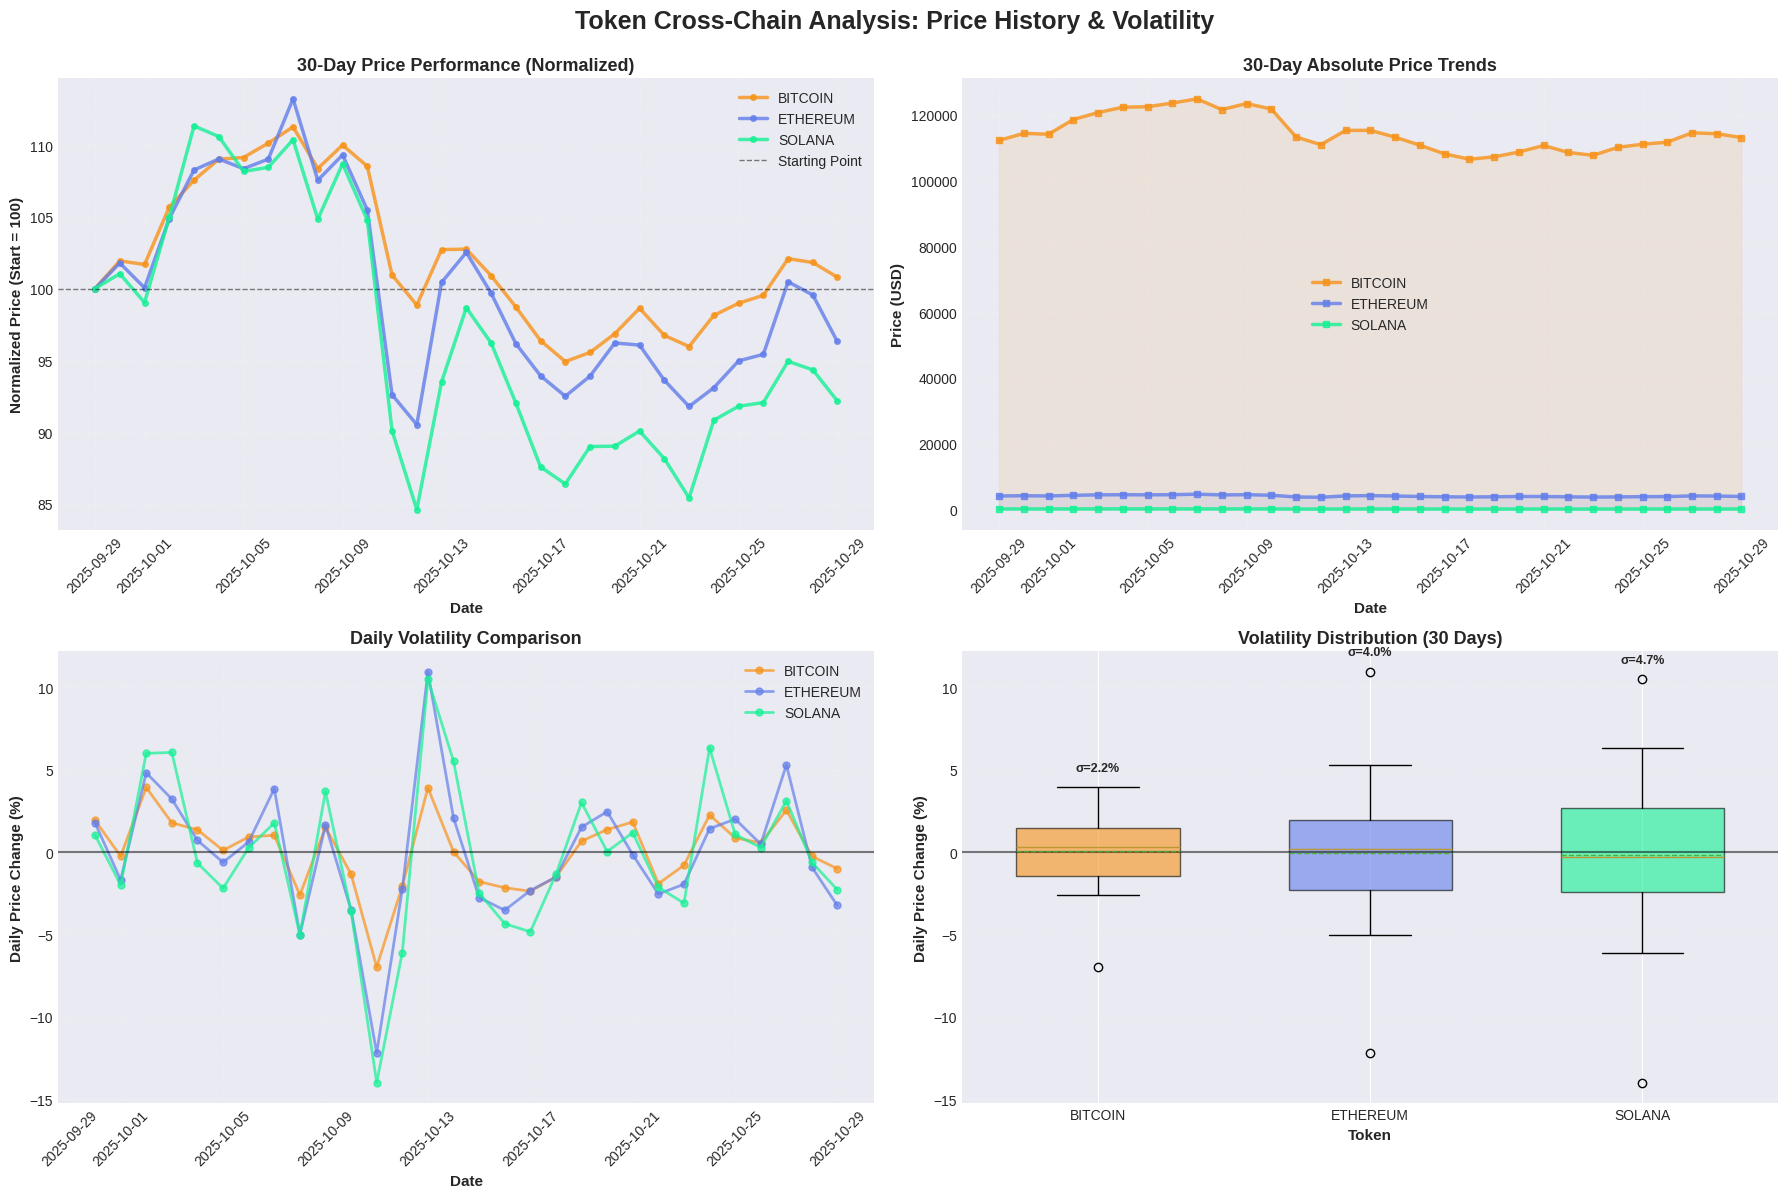


TOKEN VOLATILITY STATISTICS (30 Days)

BITCOIN:
  30-day return: +0.80%
  Avg daily change: +0.05%
  Volatility (std): 2.24%
  Max daily gain: +3.93%
  Max daily loss: -6.98%

ETHEREUM:
  30-day return: -3.68%
  Avg daily change: -0.05%
  Volatility (std): 4.01%
  Max daily gain: +10.95%
  Max daily loss: -12.20%

SOLANA:
  30-day return: -7.82%
  Avg daily change: -0.16%
  Volatility (std): 4.71%
  Max daily gain: +10.51%
  Max daily loss: -14.00%

[SUCCESS] Price history visualization complete



In [37]:
# Visualization: Token Price History and Cross-Chain Analysis

print("\n[INFO] Fetching historical price data for time-series analysis...\n")

# Fetch 30-day price history for the tokens
def get_token_price_history(coingecko_id: str, days: int = 30) -> pd.DataFrame:
    """Fetch historical price data from CoinGecko."""
    url = f"{API_ENDPOINTS['coingecko']}/coins/{coingecko_id}/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days,
        'interval': 'daily'
    }
    
    data = api_call(url, params=params)
    
    if data and 'prices' in data:
        prices = data['prices']
        market_caps = data.get('market_caps', [])
        
        df = pd.DataFrame({
            'timestamp': [p[0] for p in prices],
            'price': [p[1] for p in prices],
            'market_cap': [m[1] for m in market_caps] if market_caps else [0] * len(prices)
        })
        
        df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['token'] = coingecko_id
        
        return df[['date', 'token', 'price', 'market_cap']]
    
    return pd.DataFrame()

# Fetch price history
tokens_to_plot = ['bitcoin', 'ethereum', 'solana']
price_histories = {}

for token in tokens_to_plot:
    print(f"[INFO] Fetching {token.upper()} price history...")
    history = get_token_price_history(token, days=30)
    if not history.empty:
        price_histories[token] = history
        print(f"  [SUCCESS] Fetched {len(history)} days of data")
    else:
        print(f"  [WARNING] Failed to fetch data for {token}")

# Create comprehensive visualization
if price_histories:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Token Cross-Chain Analysis: Price History & Volatility', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    colors = {'bitcoin': '#F7931A', 'ethereum': '#627EEA', 'solana': '#14F195'}
    
    # Plot 1: Price History (Normalized)
    ax1 = axes[0, 0]
    for token, history in price_histories.items():
        if not history.empty:
            # Normalize prices to start at 100
            initial_price = history['price'].iloc[0]
            normalized = (history['price'] / initial_price) * 100
            
            ax1.plot(history['date'], normalized, 
                    label=token.upper(), linewidth=2.5, 
                    color=colors.get(token, 'gray'), marker='o', markersize=4, alpha=0.8)
    
    ax1.axhline(y=100, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Starting Point')
    ax1.set_ylabel('Normalized Price (Start = 100)', fontsize=11, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax1.set_title('30-Day Price Performance (Normalized)', fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=10, framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle=':')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Absolute Price Trends
    ax2 = axes[0, 1]
    for token, history in price_histories.items():
        if not history.empty:
            ax2.plot(history['date'], history['price'], 
                    label=token.upper(), linewidth=2.5, 
                    color=colors.get(token, 'gray'), marker='s', markersize=4, alpha=0.8)
            ax2.fill_between(history['date'], history['price'], alpha=0.1, color=colors.get(token, 'gray'))
    
    ax2.set_ylabel('Price (USD)', fontsize=11, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax2.set_title('30-Day Absolute Price Trends', fontsize=13, fontweight='bold')
    ax2.legend(loc='best', fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle=':')
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Daily Price Change (%)
    ax3 = axes[1, 0]
    for token, history in price_histories.items():
        if not history.empty and len(history) > 1:
            # Calculate daily percentage change
            history_copy = history.copy()
            history_copy['pct_change'] = history_copy['price'].pct_change() * 100
            
            ax3.plot(history_copy['date'][1:], history_copy['pct_change'][1:], 
                    label=token.upper(), linewidth=2, 
                    color=colors.get(token, 'gray'), marker='o', markersize=5, alpha=0.7)
    
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
    ax3.set_ylabel('Daily Price Change (%)', fontsize=11, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax3.set_title('Daily Volatility Comparison', fontsize=13, fontweight='bold')
    ax3.legend(loc='best', fontsize=10, framealpha=0.9)
    ax3.grid(True, alpha=0.3, linestyle=':')
    ax3.tick_params(axis='x', rotation=45)
    
    # Plot 4: Volatility Statistics (Box Plot)
    ax4 = axes[1, 1]
    volatility_data = []
    labels_vol = []
    
    for token, history in price_histories.items():
        if not history.empty and len(history) > 1:
            history_copy = history.copy()
            history_copy['pct_change'] = history_copy['price'].pct_change() * 100
            volatility_data.append(history_copy['pct_change'][1:].dropna())
            labels_vol.append(token.upper())
    
    if volatility_data:
        bp = ax4.boxplot(volatility_data, labels=labels_vol, patch_artist=True,
                         widths=0.6, showmeans=True, meanline=True)
        
        # Color the boxes
        for patch, token in zip(bp['boxes'], labels_vol):
            patch.set_facecolor(colors.get(token.lower(), 'gray'))
            patch.set_alpha(0.6)
        
        ax4.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
        ax4.set_ylabel('Daily Price Change (%)', fontsize=11, fontweight='bold')
        ax4.set_xlabel('Token', fontsize=11, fontweight='bold')
        ax4.set_title('Volatility Distribution (30 Days)', fontsize=13, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y', linestyle=':')
        
        # Add volatility stats
        for i, (token, data) in enumerate(zip(labels_vol, volatility_data)):
            std = data.std()
            ax4.text(i+1, data.max() + 1, f'σ={std:.1f}%', 
                    ha='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n" + "="*80)
    print("TOKEN VOLATILITY STATISTICS (30 Days)")
    print("="*80)
    
    for token, history in price_histories.items():
        if not history.empty and len(history) > 1:
            history_copy = history.copy()
            history_copy['pct_change'] = history_copy['price'].pct_change() * 100
            
            pct_changes = history_copy['pct_change'][1:].dropna()
            
            print(f"\n{token.upper()}:")
            print(f"  30-day return: {((history_copy['price'].iloc[-1] / history_copy['price'].iloc[0]) - 1) * 100:+.2f}%")
            print(f"  Avg daily change: {pct_changes.mean():+.2f}%")
            print(f"  Volatility (std): {pct_changes.std():.2f}%")
            print(f"  Max daily gain: {pct_changes.max():+.2f}%")
            print(f"  Max daily loss: {pct_changes.min():+.2f}%")
    
    print("\n[SUCCESS] Price history visualization complete")

else:
    print("[ERROR] No price history data available")

print("\n" + "="*80)


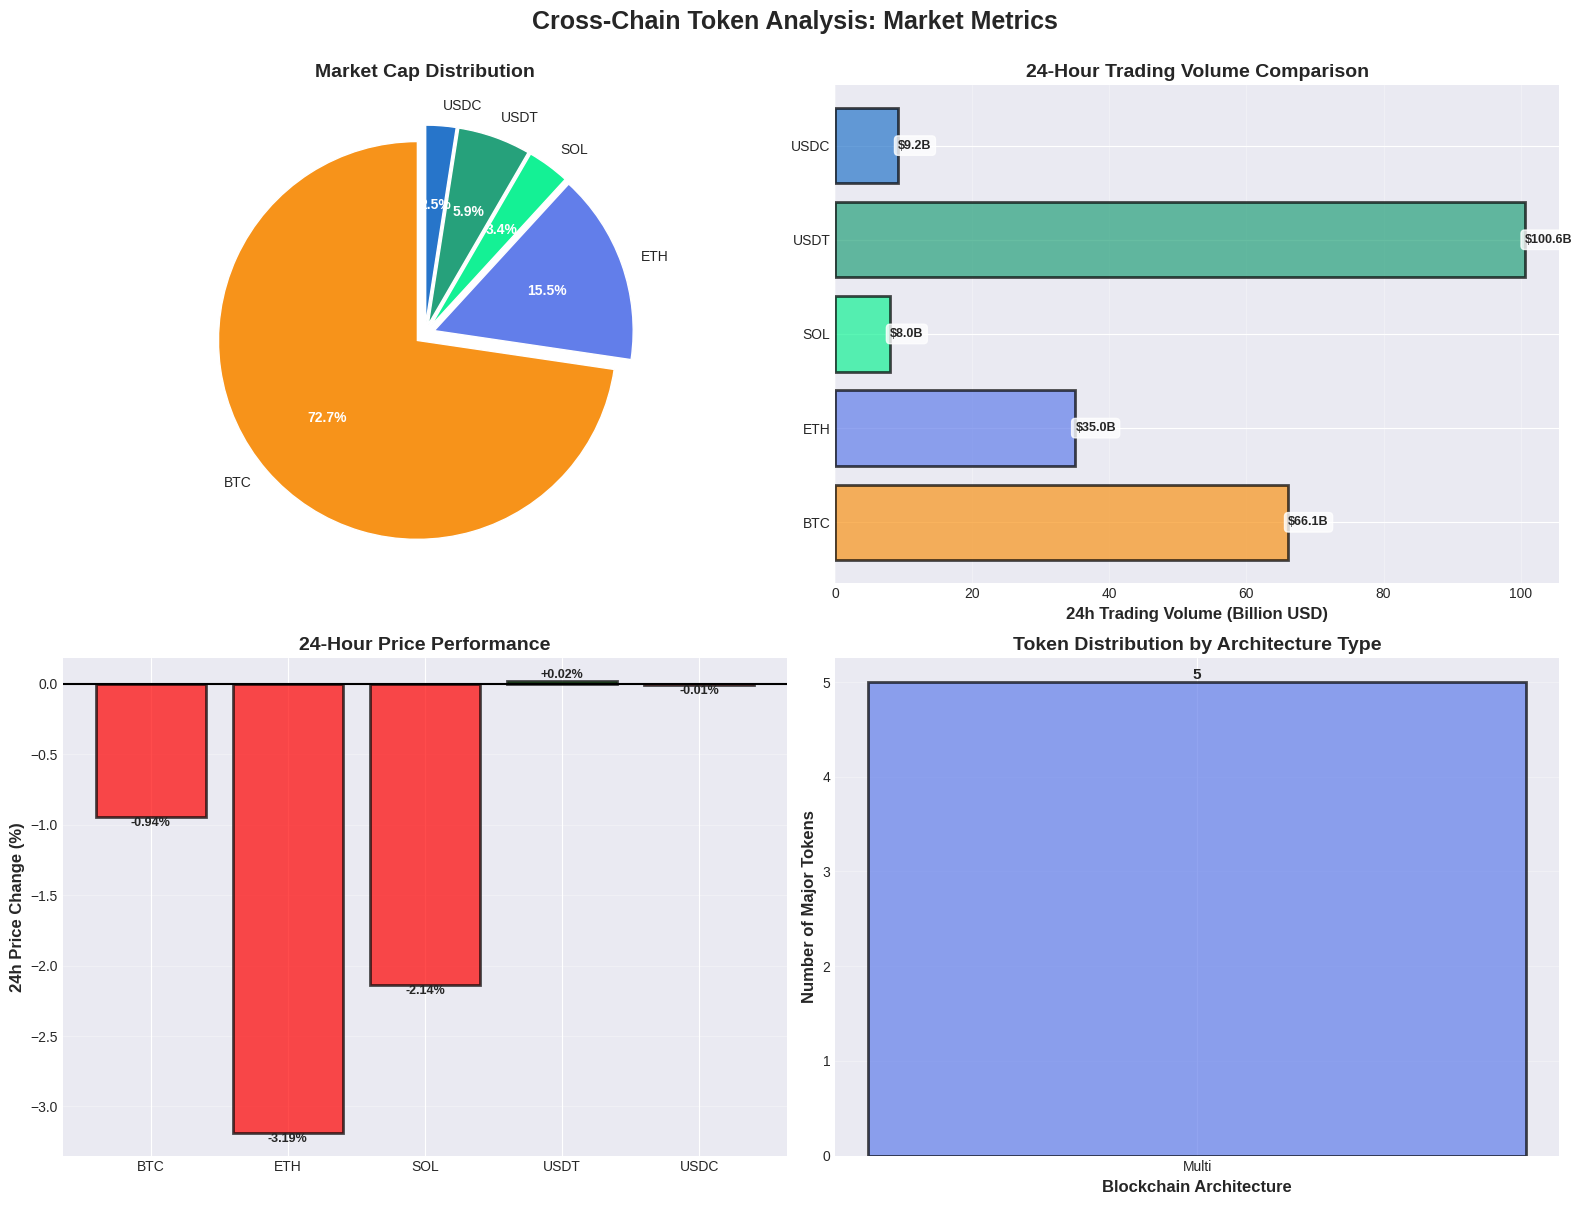


[SUCCESS] Market visualization complete


In [38]:
# Visualization 2: Token Distribution and Market Analysis

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cross-Chain Token Analysis: Market Metrics', fontsize=18, fontweight='bold', y=1.00)

# Plot 1: Market Cap Distribution
ax1 = axes[0, 0]
colors_tokens = ['#F7931A', '#627EEA', '#14F195', '#26A17B', '#2775CA']
market_caps = df_market['Market Cap (USD)'] / 1e9  # Convert to billions

wedges, texts, autotexts = ax1.pie(market_caps, 
                                     labels=df_market['Symbol'],
                                     autopct='%1.1f%%',
                                     colors=colors_tokens,
                                     startangle=90,
                                     explode=[0.05]*len(market_caps))

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

ax1.set_title('Market Cap Distribution', fontsize=14, fontweight='bold')

# Plot 2: 24h Trading Volume
ax2 = axes[0, 1]
volumes = df_market['24h Volume (USD)'] / 1e9  # Convert to billions

bars = ax2.barh(df_market['Symbol'], volumes, color=colors_tokens, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_xlabel('24h Trading Volume (Billion USD)', fontsize=12, fontweight='bold')
ax2.set_title('24-Hour Trading Volume Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

for bar, vol in zip(bars, volumes):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
             f'${vol:.1f}B', ha='left', va='center', fontweight='bold', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Plot 3: Price Performance (24h Change)
ax3 = axes[1, 0]
changes = df_market['24h Change (%)']
colors_change = ['green' if x > 0 else 'red' for x in changes]

bars3 = ax3.bar(df_market['Symbol'], changes, color=colors_change, alpha=0.7, edgecolor='black', linewidth=2)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax3.set_ylabel('24h Price Change (%)', fontsize=12, fontweight='bold')
ax3.set_title('24-Hour Price Performance', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

for bar, change in zip(bars3, changes):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{change:+.2f}%', ha='center', va='bottom' if height > 0 else 'top',
             fontweight='bold', fontsize=9)

# Plot 4: Token Distribution by Architecture
ax4 = axes[1, 1]
arch_counts = df_tokens['architecture'].value_counts()

colors_arch = ['#627EEA', '#F7931A', '#14F195', '#9945FF']
bars4 = ax4.bar(arch_counts.index, arch_counts.values, color=colors_arch[:len(arch_counts)], 
                alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Number of Major Tokens', fontsize=12, fontweight='bold')
ax4.set_xlabel('Blockchain Architecture', fontsize=12, fontweight='bold')
ax4.set_title('Token Distribution by Architecture Type', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n[SUCCESS] Market visualization complete")


[INFO] Generating advanced statistical visualizations...



/tmp/ipykernel_465218/2991707458.py:282: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


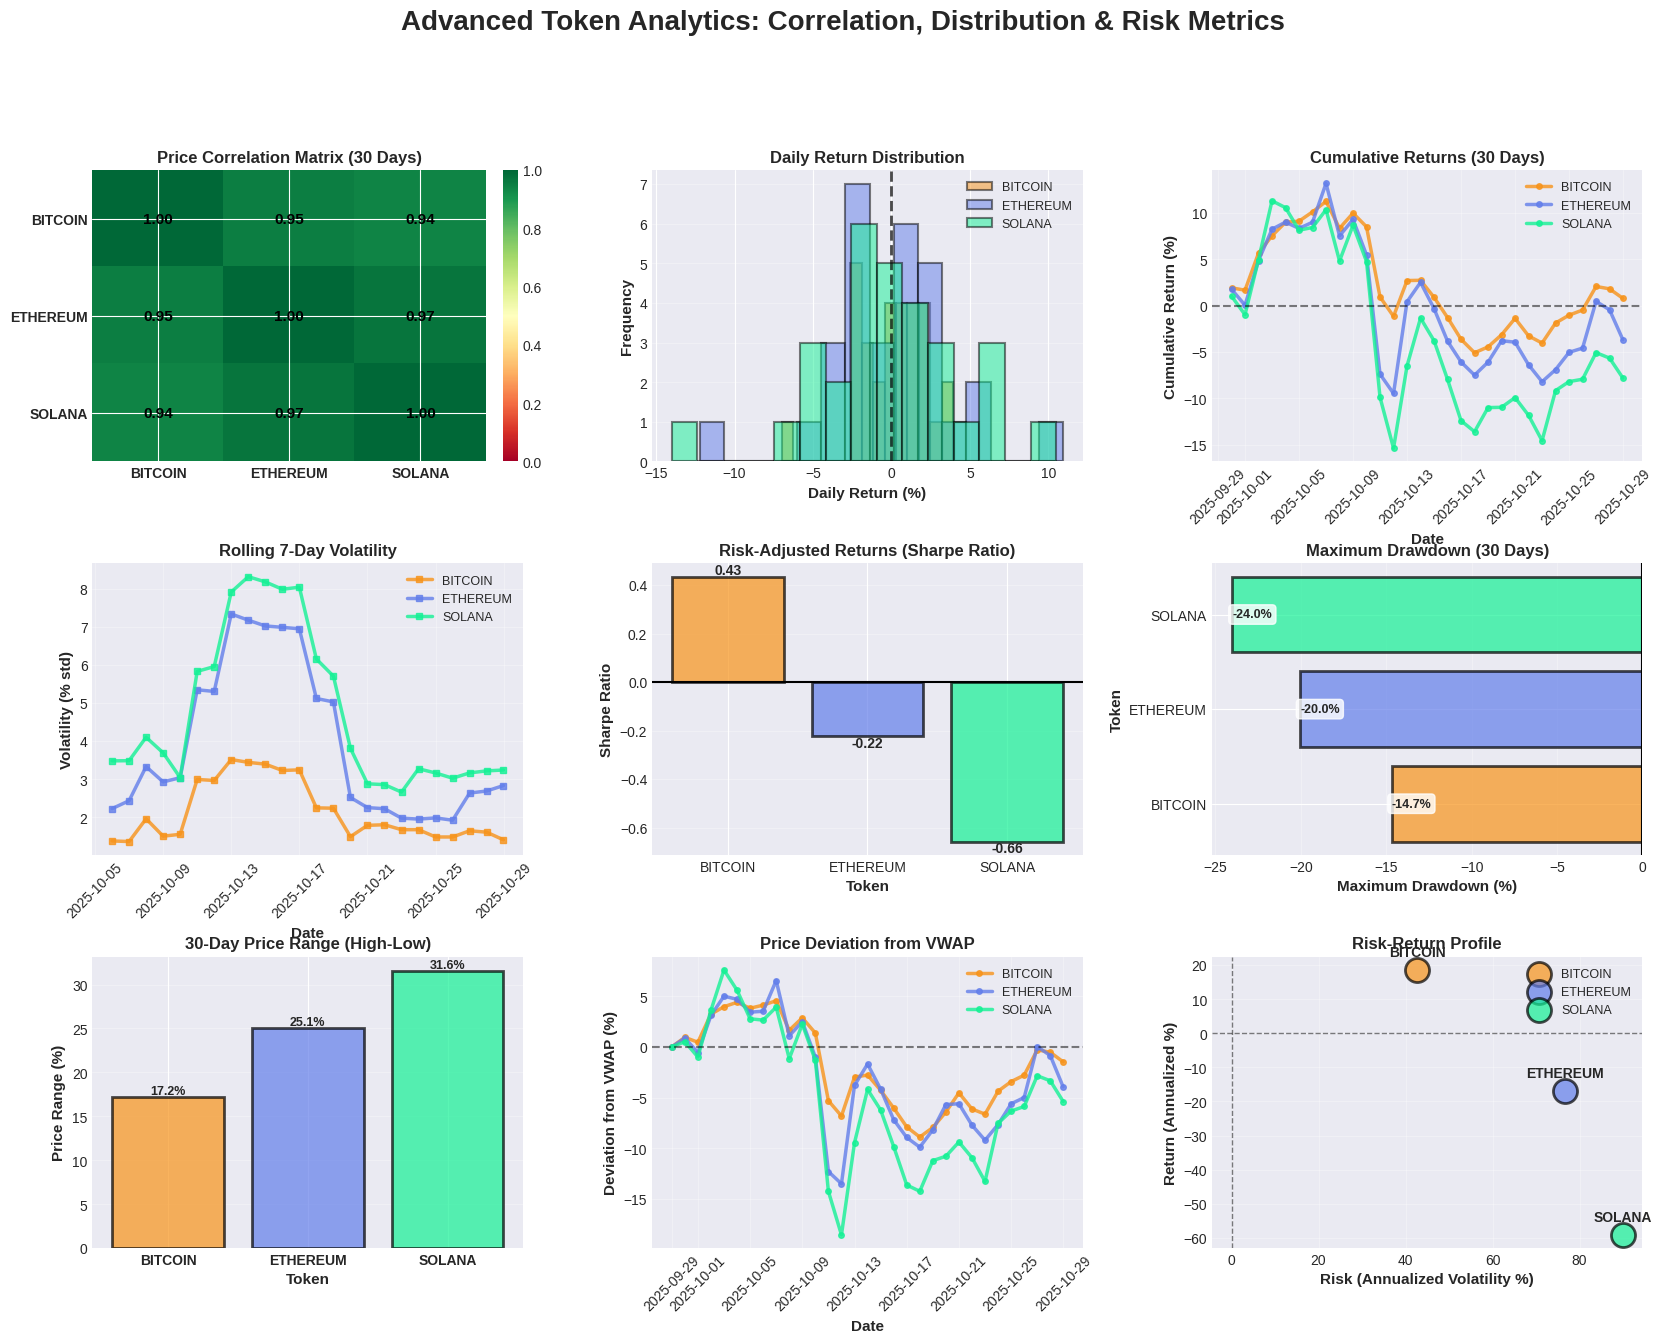


ADVANCED TOKEN ANALYTICS SUMMARY

BITCOIN:
  Annualized Return: +18.56%
  Annualized Volatility: 42.70%
  Sharpe Ratio: 0.43
  Maximum Drawdown: -14.69%
  30-Day Price Range: 17.22%
  Skewness: -0.84
  Kurtosis: 2.05

ETHEREUM:
  Annualized Return: -16.91%
  Annualized Volatility: 76.60%
  Sharpe Ratio: -0.22
  Maximum Drawdown: -20.04%
  30-Day Price Range: 25.07%
  Skewness: -0.21
  Kurtosis: 3.14

SOLANA:
  Annualized Return: -59.14%
  Annualized Volatility: 89.96%
  Sharpe Ratio: -0.66
  Maximum Drawdown: -24.00%
  30-Day Price Range: 31.58%
  Skewness: -0.35
  Kurtosis: 1.73

[SUCCESS] Advanced analytics visualization complete


In [40]:
# Visualization 3: Advanced Token Analytics and Correlation Analysis

print("\n[INFO] Generating advanced statistical visualizations...\n")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
fig.suptitle('Advanced Token Analytics: Correlation, Distribution & Risk Metrics', 
             fontsize=20, fontweight='bold', y=0.995)

colors = {'bitcoin': '#F7931A', 'ethereum': '#627EEA', 'solana': '#14F195'}

# --- Chart 1: Price Correlation Matrix ---
ax1 = fig.add_subplot(gs[0, 0])

if price_histories:
    # Create correlation matrix
    correlation_data = {}
    for token, history in price_histories.items():
        if not history.empty:
            correlation_data[token.upper()] = history.set_index('date')['price']
    
    if correlation_data:
        df_corr = pd.DataFrame(correlation_data)
        corr_matrix = df_corr.corr()
        
        # Create heatmap
        im = ax1.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        
        # Set ticks and labels
        ax1.set_xticks(range(len(corr_matrix.columns)))
        ax1.set_yticks(range(len(corr_matrix.index)))
        ax1.set_xticklabels(corr_matrix.columns, fontsize=10, fontweight='bold')
        ax1.set_yticklabels(corr_matrix.index, fontsize=10, fontweight='bold')
        
        # Add correlation values
        for i in range(len(corr_matrix.index)):
            for j in range(len(corr_matrix.columns)):
                text = ax1.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                               ha='center', va='center', color='black', 
                               fontsize=11, fontweight='bold')
        
        plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
        ax1.set_title('Price Correlation Matrix (30 Days)', fontsize=12, fontweight='bold')

# --- Chart 2: Return Distribution Histograms ---
ax2 = fig.add_subplot(gs[0, 1])

for token, history in price_histories.items():
    if not history.empty and len(history) > 1:
        history_copy = history.copy()
        history_copy['returns'] = history_copy['price'].pct_change() * 100
        returns = history_copy['returns'][1:].dropna()
        
        ax2.hist(returns, bins=15, alpha=0.5, label=token.upper(), 
                color=colors.get(token, 'gray'), edgecolor='black', linewidth=1.5)

ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xlabel('Daily Return (%)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Daily Return Distribution', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9, framealpha=0.9)
ax2.grid(True, alpha=0.3, axis='y')

# --- Chart 3: Cumulative Returns ---
ax3 = fig.add_subplot(gs[0, 2])

for token, history in price_histories.items():
    if not history.empty and len(history) > 1:
        history_copy = history.copy()
        history_copy['returns'] = history_copy['price'].pct_change()
        history_copy['cumulative'] = (1 + history_copy['returns']).cumprod() - 1
        
        ax3.plot(history_copy['date'], history_copy['cumulative'] * 100,
                label=token.upper(), linewidth=2.5, color=colors.get(token, 'gray'),
                marker='o', markersize=4, alpha=0.8)

ax3.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cumulative Return (%)', fontsize=11, fontweight='bold')
ax3.set_title('Cumulative Returns (30 Days)', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9, framealpha=0.9)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# --- Chart 4: Rolling Volatility (7-Day) ---
ax4 = fig.add_subplot(gs[1, 0])

for token, history in price_histories.items():
    if not history.empty and len(history) > 7:
        history_copy = history.copy()
        history_copy['returns'] = history_copy['price'].pct_change() * 100
        history_copy['rolling_vol'] = history_copy['returns'].rolling(window=7).std()
        
        ax4.plot(history_copy['date'][7:], history_copy['rolling_vol'][7:],
                label=token.upper(), linewidth=2.5, color=colors.get(token, 'gray'),
                marker='s', markersize=4, alpha=0.8)

ax4.set_xlabel('Date', fontsize=11, fontweight='bold')
ax4.set_ylabel('Volatility (% std)', fontsize=11, fontweight='bold')
ax4.set_title('Rolling 7-Day Volatility', fontsize=12, fontweight='bold')
ax4.legend(loc='best', fontsize=9, framealpha=0.9)
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# --- Chart 5: Sharpe Ratio Comparison ---
ax5 = fig.add_subplot(gs[1, 1])

sharpe_ratios = []
token_names = []

for token, history in price_histories.items():
    if not history.empty and len(history) > 1:
        history_copy = history.copy()
        history_copy['returns'] = history_copy['price'].pct_change()
        
        returns = history_copy['returns'][1:].dropna()
        if len(returns) > 0:
            # Annualized Sharpe Ratio (assuming 365 days, risk-free rate = 0)
            mean_return = returns.mean() * 365
            std_return = returns.std() * np.sqrt(365)
            sharpe = mean_return / std_return if std_return > 0 else 0
            
            sharpe_ratios.append(sharpe)
            token_names.append(token.upper())

if sharpe_ratios:
    bars = ax5.bar(token_names, sharpe_ratios, 
                   color=[colors.get(t.lower(), 'gray') for t in token_names],
                   alpha=0.7, edgecolor='black', linewidth=2)
    
    ax5.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax5.set_ylabel('Sharpe Ratio', fontsize=11, fontweight='bold')
    ax5.set_xlabel('Token', fontsize=11, fontweight='bold')
    ax5.set_title('Risk-Adjusted Returns (Sharpe Ratio)', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    
    for bar, sr in zip(bars, sharpe_ratios):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{sr:.2f}', ha='center', va='bottom' if height > 0 else 'top',
                fontweight='bold', fontsize=10)

# --- Chart 6: Max Drawdown Analysis ---
ax6 = fig.add_subplot(gs[1, 2])

drawdowns = []
token_names_dd = []

for token, history in price_histories.items():
    if not history.empty:
        history_copy = history.copy()
        history_copy['cummax'] = history_copy['price'].cummax()
        history_copy['drawdown'] = (history_copy['price'] - history_copy['cummax']) / history_copy['cummax'] * 100
        
        max_drawdown = history_copy['drawdown'].min()
        drawdowns.append(max_drawdown)
        token_names_dd.append(token.upper())

if drawdowns:
    bars = ax6.barh(token_names_dd, drawdowns,
                    color=[colors.get(t.lower(), 'gray') for t in token_names_dd],
                    alpha=0.7, edgecolor='black', linewidth=2)
    
    ax6.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
    ax6.set_xlabel('Maximum Drawdown (%)', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Token', fontsize=11, fontweight='bold')
    ax6.set_title('Maximum Drawdown (30 Days)', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='x')
    
    for bar, dd in zip(bars, drawdowns):
        width = bar.get_width()
        ax6.text(width, bar.get_y() + bar.get_height()/2.,
                f'{dd:.1f}%', ha='left', va='center',
                fontweight='bold', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# --- Chart 7: Price Range (High-Low) ---
ax7 = fig.add_subplot(gs[2, 0])

ranges = []
token_names_range = []
range_pcts = []

for token, history in price_histories.items():
    if not history.empty:
        price_high = history['price'].max()
        price_low = history['price'].min()
        price_range = price_high - price_low
        range_pct = (price_range / price_low) * 100
        
        ranges.append(price_range)
        range_pcts.append(range_pct)
        token_names_range.append(token.upper())

if ranges:
    x = np.arange(len(token_names_range))
    bars = ax7.bar(x, range_pcts,
                   color=[colors.get(t.lower(), 'gray') for t in token_names_range],
                   alpha=0.7, edgecolor='black', linewidth=2)
    
    ax7.set_xticks(x)
    ax7.set_xticklabels(token_names_range, fontsize=10, fontweight='bold')
    ax7.set_ylabel('Price Range (%)', fontsize=11, fontweight='bold')
    ax7.set_xlabel('Token', fontsize=11, fontweight='bold')
    ax7.set_title('30-Day Price Range (High-Low)', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3, axis='y')
    
    for bar, pct in zip(bars, range_pcts):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom',
                fontweight='bold', fontsize=9)

# --- Chart 8: Volume-Weighted Average Price (VWAP) Deviation ---
ax8 = fig.add_subplot(gs[2, 1])

# Use market cap as proxy for volume weighting
for token, history in price_histories.items():
    if not history.empty and 'market_cap' in history.columns:
        history_copy = history.copy()
        
        # Calculate VWAP
        total_volume = history_copy['market_cap'].sum()
        if total_volume > 0:
            history_copy['vwap'] = (history_copy['price'] * history_copy['market_cap']).cumsum() / history_copy['market_cap'].cumsum()
            history_copy['vwap_dev'] = (history_copy['price'] - history_copy['vwap']) / history_copy['vwap'] * 100
            
            ax8.plot(history_copy['date'], history_copy['vwap_dev'],
                    label=token.upper(), linewidth=2.5, color=colors.get(token, 'gray'),
                    marker='o', markersize=4, alpha=0.8)

ax8.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax8.set_xlabel('Date', fontsize=11, fontweight='bold')
ax8.set_ylabel('Deviation from VWAP (%)', fontsize=11, fontweight='bold')
ax8.set_title('Price Deviation from VWAP', fontsize=12, fontweight='bold')
ax8.legend(loc='best', fontsize=9, framealpha=0.9)
ax8.grid(True, alpha=0.3)
ax8.tick_params(axis='x', rotation=45)

# --- Chart 9: Risk-Return Scatter Plot ---
ax9 = fig.add_subplot(gs[2, 2])

risk_return_data = []

for token, history in price_histories.items():
    if not history.empty and len(history) > 1:
        history_copy = history.copy()
        history_copy['returns'] = history_copy['price'].pct_change()
        
        returns = history_copy['returns'][1:].dropna()
        if len(returns) > 0:
            avg_return = returns.mean() * 365 * 100  # Annualized %
            volatility = returns.std() * np.sqrt(365) * 100  # Annualized %
            
            risk_return_data.append({
                'token': token.upper(),
                'return': avg_return,
                'risk': volatility
            })

if risk_return_data:
    for data in risk_return_data:
        ax9.scatter(data['risk'], data['return'], 
                   s=300, alpha=0.7, 
                   color=colors.get(data['token'].lower(), 'gray'),
                   edgecolors='black', linewidth=2,
                   label=data['token'])
        
        ax9.annotate(data['token'], 
                    (data['risk'], data['return']),
                    textcoords="offset points", xytext=(0,10),
                    ha='center', fontsize=10, fontweight='bold')
    
    ax9.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax9.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax9.set_xlabel('Risk (Annualized Volatility %)', fontsize=11, fontweight='bold')
    ax9.set_ylabel('Return (Annualized %)', fontsize=11, fontweight='bold')
    ax9.set_title('Risk-Return Profile', fontsize=12, fontweight='bold')
    ax9.grid(True, alpha=0.3)
    ax9.legend(loc='best', fontsize=9, framealpha=0.9)

plt.tight_layout()
plt.show()

# Print advanced statistics
print("\n" + "="*80)
print("ADVANCED TOKEN ANALYTICS SUMMARY")
print("="*80)

for token, history in price_histories.items():
    if not history.empty and len(history) > 1:
        history_copy = history.copy()
        history_copy['returns'] = history_copy['price'].pct_change()
        returns = history_copy['returns'][1:].dropna()
        
        if len(returns) > 0:
            # Calculate metrics
            mean_return = returns.mean() * 365 * 100
            std_return = returns.std() * np.sqrt(365) * 100
            sharpe = (returns.mean() * 365) / (returns.std() * np.sqrt(365)) if returns.std() > 0 else 0
            
            # Drawdown
            history_copy['cummax'] = history_copy['price'].cummax()
            history_copy['drawdown'] = (history_copy['price'] - history_copy['cummax']) / history_copy['cummax'] * 100
            max_dd = history_copy['drawdown'].min()
            
            # Range
            price_range = ((history_copy['price'].max() - history_copy['price'].min()) / history_copy['price'].min()) * 100
            
            print(f"\n{token.upper()}:")
            print(f"  Annualized Return: {mean_return:+.2f}%")
            print(f"  Annualized Volatility: {std_return:.2f}%")
            print(f"  Sharpe Ratio: {sharpe:.2f}")
            print(f"  Maximum Drawdown: {max_dd:.2f}%")
            print(f"  30-Day Price Range: {price_range:.2f}%")
            print(f"  Skewness: {returns.skew():.2f}")
            print(f"  Kurtosis: {returns.kurtosis():.2f}")

print("\n[SUCCESS] Advanced analytics visualization complete")
print("="*80)

### Analysis: Cross-Chain Token Strategy

**Key Takeaways:**

1. **Liquidity Fragmentation**
   - Same asset exists on multiple chains with different liquidity profiles
   - USDC on Ethereum has deeper liquidity than USDC on Solana
   - Trading strategy must account for chain-specific liquidity

2. **Wrapped Token Risks**
   - Bridge risk: Smart contract vulnerabilities (historical bridge hacks)
   - Custody risk: Who holds the underlying collateral?
   - Depeg risk: Temporary price discrepancies during high volatility

3. **Arbitrage Opportunities**
   - Price differences between native and wrapped versions
   - Cross-chain DEX price discrepancies
   - Must factor in: bridge fees, gas costs, time delays

4. **Strategic Considerations**
   - **For Large Trades**: Use native chain for deepest liquidity
   - **For DeFi**: Wrapped tokens enable composability (e.g., WBTC in Ethereum DeFi)
   - **For Speed**: Solana versions for rapid execution
   - **For Security**: Native chains have longest track record